In [1]:
# 挂载 google 云盘
from google.colab import drive
drive.mount('/content/gdrive')

# 将文件路径指定为数据路径
import os
os.chdir('/content/gdrive/My Drive/comment')

import numpy as np
import pandas as pd

from tqdm import tqdm #显示运行进度条

# 画图库
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sb
import matplotlib.pyplot as plt

# 文字处理库
from keras.preprocessing.text import Tokenizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
# nltk.download('stopwords') #下载停止词
import string
from keras.preprocessing import sequence
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve,auc,roc_auc_score
from keras.preprocessing.text import text_to_word_sequence

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Using TensorFlow backend.


In [2]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
nltk.download('stopwords') #下载停止词
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
labels = train_data.columns[2:].tolist()
# tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

all_comments = pd.concat([train_data['comment_text'], test_data['comment_text']])
stop_words = set(stopwords.words('english'))
# stop_words.update(string.punctuation)

comments_refined = []
print('正在处理文本......')
for line in tqdm(all_comments):
    word_seq = text_to_word_sequence(line,
                              filters=string.punctuation+'\n\t0123456789',
                              lower=True,
                              split=" ")
    comments_refined.append(' '.join([word for word in word_seq if word not in stop_words]))
vectorizer = TfidfVectorizer( strip_accents='unicode',
                              analyzer='word',
                              use_idf=True,
                              smooth_idf=True,
                              sublinear_tf=True,
                              max_features=10000
                              ).fit(comments_refined)
train_features, test_features = map(lambda x: vectorizer.transform(tqdm(x)), 
                                    [train_data['comment_text'], 
                                     test_data['comment_text']])

print('文本处理完成！')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  1%|          | 2215/312735 [00:00<00:14, 22142.26it/s]

正在处理文本......


100%|██████████| 153164/153164 [00:08<00:00, 17495.17it/s]


文本处理完成！


  0%|          | 0/6 [00:00<?, ?it/s]

在toxic类上的分类准确率为0.9598


 17%|█▋        | 1/6 [00:18<01:30, 18.03s/it]

在severe_toxic类上的分类准确率为0.9905


 33%|███▎      | 2/6 [00:37<01:13, 18.49s/it]

在obscene类上的分类准确率为0.9787


 50%|█████     | 3/6 [00:54<00:54, 18.07s/it]

在threat类上的分类准确率为0.9972


 67%|██████▋   | 4/6 [01:11<00:35, 17.82s/it]

在insult类上的分类准确率为0.9717


 83%|████████▎ | 5/6 [01:30<00:18, 18.02s/it]

在identity_hate类上的分类准确率为0.9921


100%|██████████| 6/6 [01:48<00:00, 18.13s/it]


平均准确率为0.9817


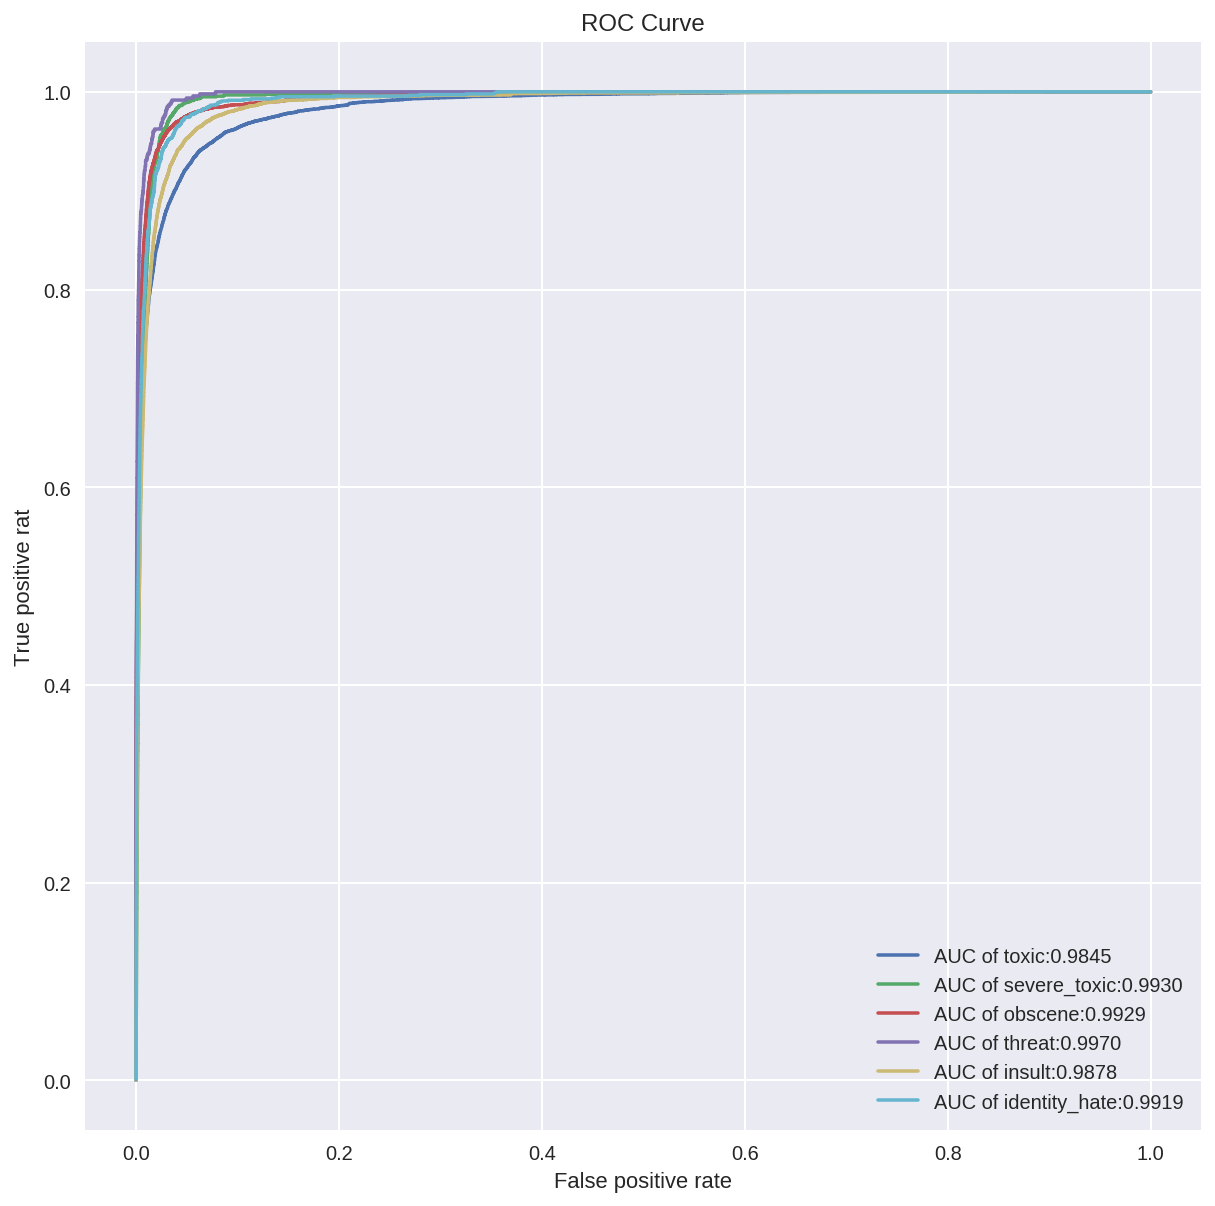

In [3]:
class_dict = {}
acc_scores = []
plt.figure(figsize=(10,10))
for label in tqdm(labels):
    classifier = LogisticRegression(C=4,solver='sag')
    acc_scores.append(cross_val_score( classifier, 
                                       train_features, 
                                       train_data[label], 
                                       cv=5, 
                                       scoring='accuracy'))
    print('在{}类上的分类准确率为{:.4f}'.format(label, np.mean(acc_scores[-1])))
    classifier.fit(train_features, train_data[label])
    probs = classifier.predict_proba(train_features)[:,1]
    fpr,tpr,thres = roc_curve(train_data[label],probs)
    area =roc_auc_score(train_data[label],probs)
    plt.plot(fpr,tpr,label= 'AUC of {}:{:.4f}'.format(label, area))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rat')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    class_dict[label] = classifier
print('平均准确率为{:.4f}'.format(np.mean(acc_scores)))
plt.show()

In [4]:
submission = pd.DataFrame.from_dict({'id': test_data['id']})
for label in tqdm(labels):
  submission[label] = class_dict[label].predict_proba(test_features)[:,1]
submission.to_csv('Logistic Regression with Tfidf.csv', index=False)

100%|██████████| 6/6 [00:00<00:00, 57.24it/s]


In [0]:
# # https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
# from sklearn.svm import SVC
# vectorizer = TfidfVectorizer(
#     strip_accents='unicode',
#     analyzer='word',
#     use_idf=True,
#     smooth_idf=True,
#     sublinear_tf=True,
#     max_features=1000
# #     max_features=50000
#     ).fit(comments_refined)
# train_features, test_features = map(lambda x: vectorizer.transform(x), 
#                                     [train_data['comment_text'], test_data['comment_text']] )

# # from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import AdaBoostClassifier
# cv_scores = []
# submission = pd.DataFrame.from_dict({'id': test_data['id']})
# for label in tqdm(labels):
#     classifier = AdaBoostClassifier(LogisticRegression(max_iter = 1000,
#                                                        solver='sag'))
    
#     cv_scores.append(cross_val_score(  classifier, 
#                                        train_features, 
#                                        train_data[label], 
#                                        cv=5, 
#                                        scoring='roc_auc'))
#     classifier.fit(train_features, train_data[label])
#     submission[label] = classifier.predict_proba(test_features)[:, 1]

# print('Total CV score is {}'.format(np.mean(cv_scores)))
# plt.figure(figsize=[10,8])
# for score in cv_scores:
#     plt.plot(['cv1','cv2','cv3','cv4','cv5'], score)
# plt.legend(labels, loc='upper right')
# submission.to_csv('submission_simple.csv', index=False)

* 使用 AdaBoost 进行训练

In [10]:
train_features

<159571x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 6381819 stored elements in Compressed Sparse Row format>